**Todos**
- [ ] Revisit separatrix crossing calculation

To-run list:
- [x] $\mu_p=5e-5$ random capture grid
- [x] $\mu_p=5e-5$ random capture grid w/ $\beta_p=0$
    - NEED TO FIX: $\varpi_0$ not randomly selected
- [x] $\mu_p=5e-5$ random capture grid w/ no secular effects

Wanting to plot $\phi$ over time next

- Right now, the random grid has $\varpi_0=0$ and a random $\theta_{p,0}$.. May need to check this?

# Preamble

In [1]:
from sympy import init_session
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_styles import analytic
import numpy as npy
import scipy as sp
%matplotlib widget
import os, glob, pathlib
from loky import get_reusable_executor
import dill as pickle
from sympy.utilities.lambdify import lambdastr
init_session()

IPython console for SymPy 1.12 (Python 3.12.0-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12/



In [2]:
EXPRS = {}

In [3]:
def term_simplify(expr):
    run = 0
    for arg in expr.args:
        run += arg.simplify()
    return(run)

def term_multiply(expr, mult):
    run = 0
    for term in expr.args:
        run += term*mult
    term_simplify(run)
    return(run)

In [4]:
# Positive constant
G, M, mp, ep, b, bp, j, mup, tm, b1_3_2, b2_3_2 = symbols("G M m_p e_p beta beta_p j mu_p tau_m b_{3/2}^{(1)}(\\alpha_0) b_{3/2}^{(2)}(\\alpha_0)", positive=True)
# Precession frequencies
om, omp = symbols("omega omega_p")
# Functions of time
ap, lp, np, a, l, pom, th, thp, alpha = symbols("a_p lambda_p n_p a lambda varpi theta theta_p alpha") 
# Positive functions of time
e = symbols("e", positive=True)
# Actions
Gam, Lam = symbols("Gamma Lambda", positive=True)
# Derivatives
dth, dthp = symbols(r"\dot\theta \dot\theta_p")

In [5]:
EXPRS[thp] =  (j + 1) * l - j * lp - omp * t
EXPRS[th] = (j + 1) * l - j * lp - pom

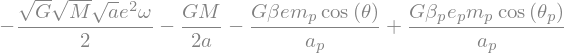

In [6]:
H_expr = - G*M/(2*a) - Rational(1,2)*sqrt(G*M*a)*e**2*om + G*mp/ap*bp*ep*cos(thp) - G*mp/ap*b*e*cos(th)
H_expr

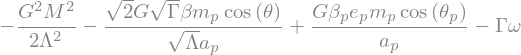

In [7]:
H = H_expr.subs(
    {
        Rational(1, 2) * sqrt(G * M * a) * e**2: Gam,
        e: sqrt(2 * Gam / Lam),
        a: Lam**2 / (G * M),
    }
)
H = term_simplify(H)
H

In [8]:
def diff(expr, var):
    run = expr.diff(var)
    for key in EXPRS.keys():
        run += expr.diff(key)*EXPRS[key].diff(var)
    return(run)

Right now, keeping ALL terms, and removing $\mathcal O(\mu_p^2)$ in the Latex document

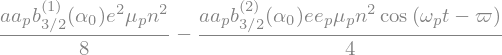

In [9]:
R = mup*n**2*a**2*Rational(1,8)*(ap/a)*b1_3_2*e**2 - mup*n**2*a**2*Rational(1,4)*(ap/a)*b2_3_2*e*ep*cos(omp*t-pom)
R

## Physical sources of apsidal precession

In [10]:
MUJUP = 9.55e-4
MUURN = 4.366e-5
MUSAT = 2.858e-4
SMAJUP = 5.20
SMAURN = 9.54
SMASAT = 19.19
def nep_omp_np(smaext, muext):
    SMANEP = 30.07
    return 0.75 * muext * (smaext / SMANEP) ** 2
alpha0val = (2 / (2 + 1)) ** (2.0 / 3)
0.75*(1-alpha0val**3.5)
DPOM_GPS = (nep_omp_np(SMAJUP,MUJUP)+nep_omp_np(SMASAT,MUSAT)+nep_omp_np(SMAURN,MUURN))*(1-alpha0val**(3.5))
DPOM_GPS

# EOMs

## $\dot \Lambda$

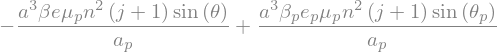

In [11]:
Lamdot = (
    -diff(H, l)
    .subs(mp, mup * M)
    .subs({sqrt(Gam): sqrt(Lam / 2) * e})
    .subs({Lam: sqrt(G * M * a)})
    .subs({sqrt(G * M): n * a ** Rational(3, 2)})
)
Lamdot

## $\dot n$

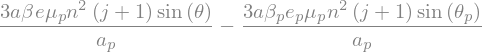

In [12]:
ndot = term_multiply(Lamdot, -3 * n**2 * a / (G * M))
ndot = (
    ndot.subs({sqrt(2 * Gam / Lam): e})
    .subs({sqrt(Gam): sqrt(Lam / 2) * e})
    .subs({Lam: sqrt(G * M * a)})
    .subs({sqrt(G * M): n * a ** Rational(3, 2)})
)
ndot

## $\dot a$

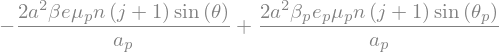

In [13]:
adot = term_multiply(Lamdot, 2/(n*a))
adot

## $\dot \Gamma$

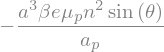

In [14]:
Gamdot = (
    diff(H, pom)
    .subs(mp, mup * M)
    .subs({sqrt(Gam): sqrt(Lam / 2) * e})
    .subs({Lam: sqrt(G * M * a)})
    .subs({sqrt(G * M): n * a ** Rational(3, 2)})
)
Gamdot

## $\dot e$

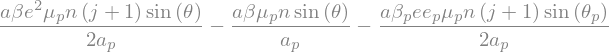

In [15]:
edot = Gamdot/(Lam*e) - term_multiply(Lamdot, Rational(1,2)/Lam*e)
edot = edot.subs({sqrt(2*Gam/Lam):e})
edot = edot.subs({Lam:sqrt(G*M*a)}).subs({sqrt(G*M):n*a**Rational(3,2)})
edot

## $\dot \varpi$

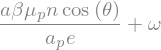

In [16]:
pomdot = (
    (-diff(H, Gam))
    .subs(mp, mup * M)
    .subs({sqrt(Gam): sqrt(Lam / 2) * e})
    .subs({Lam: sqrt(G * M * a)})
    .subs({sqrt(G * M): n * a ** Rational(3, 2)})
)
pomdot

## $\dot \lambda$

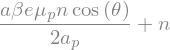

In [17]:
ldot = (
    diff(H, Lam)
    .subs(mp, mup * M)
    .subs({sqrt(Gam): sqrt(Lam / 2) * e})
    .subs({Lam: sqrt(G * M * a)})
    .subs({sqrt(G * M): n * a ** Rational(3, 2)})
)

ldot

## $\dot \theta_p$

## $\ddot\lambda$

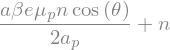

In [18]:
ldot

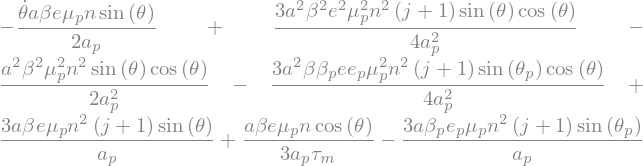

In [19]:
lddot = (
    (
        diff(ldot, th) * dth 
        +term_multiply(adot,diff(ldot, a))
        +term_multiply(edot,diff(ldot, e))
        +term_multiply(ndot,diff(ldot, n).args[0])
        +term_multiply(ndot,diff(ldot, n).args[1])
        +diff(ldot,ap)*(-2*ap/(3*tm))
    )
) 
lddot

In [20]:
#lddot = (lddot + O(mup**2)).removeO() # first order in mu_p since theres not 1/e terms
#lddot

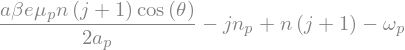

In [21]:
thpdot = term_multiply(ldot,(j+1)) - j*np - omp
thpdot

In [22]:
print(latex(thpdot))

\frac{a \beta e \mu_{p} n \left(j + 1\right) \cos{\left(\theta \right)}}{2 a_{p}} - j n_{p} + n \left(j + 1\right) - \omega_{p}


## $\ddot\theta_p$

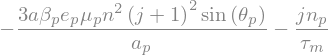

In [23]:
thpddot = term_multiply(lddot,(j+1)) - j*np/tm
thpddot.subs(b,0)

In [24]:
print(latex(thpddot.subs(a/ap,alpha**(-1))))

- \frac{\dot\theta \beta e \mu_{p} n \left(j + 1\right) \sin{\left(\theta \right)}}{2 \alpha} - \frac{j n_{p}}{\tau_{m}} + \frac{3 \beta e \mu_{p} n^{2} \left(j + 1\right)^{2} \sin{\left(\theta \right)}}{\alpha} + \frac{\beta e \mu_{p} n \left(j + 1\right) \cos{\left(\theta \right)}}{3 \alpha \tau_{m}} - \frac{3 \beta_{p} e_{p} \mu_{p} n^{2} \left(j + 1\right)^{2} \sin{\left(\theta_{p} \right)}}{\alpha} + \frac{3 \beta^{2} e^{2} \mu_{p}^{2} n^{2} \left(j + 1\right)^{2} \sin{\left(\theta \right)} \cos{\left(\theta \right)}}{4 \alpha^{2}} - \frac{\beta^{2} \mu_{p}^{2} n^{2} \left(j + 1\right) \sin{\left(\theta \right)} \cos{\left(\theta \right)}}{2 \alpha^{2}} - \frac{3 \beta \beta_{p} e e_{p} \mu_{p}^{2} n^{2} \left(j + 1\right)^{2} \sin{\left(\theta_{p} \right)} \cos{\left(\theta \right)}}{4 \alpha^{2}}


## $\dot\varpi_{\rm sec}$

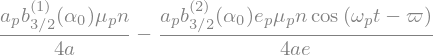

In [25]:
pomdsec = term_multiply(diff(R,e),1/(n*a**2*e))
pomdsec

## $\dot e_{\rm sec}$

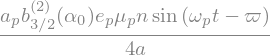

In [26]:
edsec = -diff(R,pom)/(n*a**2*e)
edsec

# Right hand side for numerical integrations

In [27]:
Eq(np,exp(-t/tm))

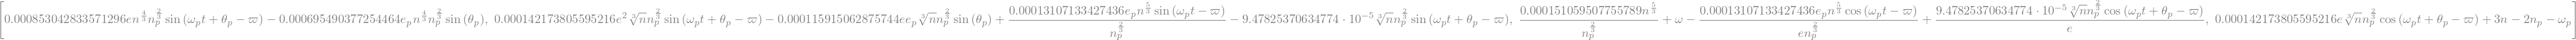

In [35]:
TMVAL = 2 * npy.pi * 1e6
convs = {}
convs = {ap: n ** Rational(2, 3) / np ** Rational(2, 3) * a, th: thp + omp * t - pom}
params = {}
params = {
    j: 2,
    mup: 5e-5,
    bp: 1.5455341716765871,
    b: 1.8956507412695471,
    b1_3_2: 12.08476062046314,
    b2_3_2: 10.485706741948807,
}

alpha0val = (params[j] / (params[j] + 1)) ** (2.0 / 3)
# params[omp] = 0
# params[om] = params[omp] * alpha0val**3.5


funs = [
    iterfun.subs(convs).subs(params)
    for iterfun in [ndot, edot + edsec, pomdot + pomdsec, thpdot]
]
funs

In [36]:
xp = [n, e, pom, thp, np, t]

In [37]:
lambdastr(xp, funs).replace("math", "npy")

'lambda n,e,varpi,theta_p,n_p,t: ([0.000853042833571296*e*n**(4/3)*n_p**(2/3)*npy.sin(omega_p*t + theta_p - varpi) - 0.000695490377254464*e_p*n**(4/3)*n_p**(2/3)*npy.sin(theta_p), 0.000142173805595216*e**2*n**(1/3)*n_p**(2/3)*npy.sin(omega_p*t + theta_p - varpi) - 0.000115915062875744*e*e_p*n**(1/3)*n_p**(2/3)*npy.sin(theta_p) + 0.00013107133427436*e_p*n**(5/3)*npy.sin(omega_p*t - varpi)/n_p**(2/3) - 9.47825370634774e-5*n**(1/3)*n_p**(2/3)*npy.sin(omega_p*t + theta_p - varpi), 0.000151059507755789*n**(5/3)/n_p**(2/3) + omega - 0.00013107133427436*e_p*n**(5/3)*npy.cos(omega_p*t - varpi)/(e*n_p**(2/3)) + 9.47825370634774e-5*n**(1/3)*n_p**(2/3)*npy.cos(omega_p*t + theta_p - varpi)/e, 0.000142173805595216*e*n**(1/3)*n_p**(2/3)*npy.cos(omega_p*t + theta_p - varpi) + 3*n - 2*n_p - omega_p])'

In [160]:
funcl = lambdify(xp, funs)


def func(t, x0):
    npval = npy.exp(-t/TMVAL)
    #npval = 1 - t / TMVAL
    return funcl(*x0, npval, t)

In [473]:
#teval = npy.linspace(0, 2 * npy.pi * 7.5e5, 10000)
#sol = sp.integrate.solve_ivp(
#    func,
#    [teval[0], teval[-1]],
#    [1/1.55, 0.001, 1, 2],
#    t_eval=teval,
#    rtol=1e-9,
#    #atol=1e-9,
#    method="DOP853",
#)

In [32]:
#fig, ax = plt.subplots()
#ax.plot(sol.t,sol.y[0,:])
#ax.plot(sol.t,sol.y[0,:]/npy.exp(-sol.t/TMVAL))
#ax.plot(sol.t,sol.y[1,:])
#ax.scatter(sol.t,sol.y[2,:]%(2*npy.pi))
#ax.scatter(sol.t,sol.y[3,:]%(2*npy.pi))
#ax.scatter(sol.t,(sol.y[3,:]+params[omp]*sol.t-sol.y[2,:])%(2*npy.pi))

## Single grid and chaos grid

In [150]:
TMVAL = 2*npy.pi*1e6
with open("results_mup5e-5_tm2pi1e6_n1.55_omalpha0val3.5_chaos_hidens.pkl", "rb") as f:
    jobs, results = pickle.load(f)

In [151]:
outcomes = []
for ind, result in enumerate(results):
    if ind % 100 == 0:
        outcomes += [0]
    params = jobs[ind]
    nRatio = results[ind].y[0,-1]/npy.exp(-results[ind].t[-1]/TMVAL)
    if len(result.t_events[0]) == 0:
        outcomes[-1] = outcomes[-1] + 1
outcomes = [outcome/100 for outcome in outcomes]

In [152]:
joblist = [jobs[100*i] for i in range(len(outcomes))]

In [153]:
#joblist = joblist + [jobs[100*i] for i in range(len(outcomes_extended))]
eplist = [job[1] for job in joblist]
Domextlist = [job[2]-job[3] for job in joblist]
indlist = [job[0] for job in joblist]
Domextlist

In [154]:
with open("results_mup5e-5_tm2pi1e6_n1.55_omalpha0val3.5.pkl", "rb") as f:
    jobs, results = pickle.load(f)

In [155]:
212, 398, 584,
198, 384, 570, 
98, 191, 284, 377, 470, 563,
112, 205, 298, 391, 484, 577
119,105
305,291
491,477

In [156]:
with open("singles_mup5e-5_tm2pi1e6_n1.55_omalpha0val3.5.pkl", "rb") as f:
    jobssingle, _ = pickle.load(f)
epsingle = [j[1] for j in jobssingle]
Dpomsingle = [j[2]-j[3] for j in jobssingle]

In [157]:
jobssingle

/var/folders/rv/30_ngz5x5l5djjdvflk_6wwm0000gn/T/ipykernel_19913/1481584289.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


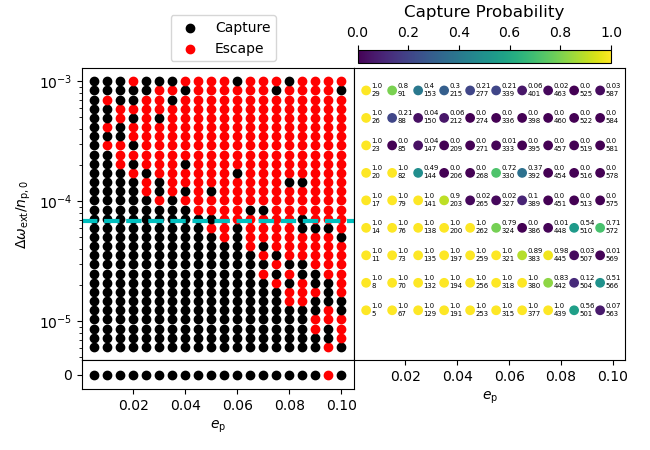

In [159]:
fig = plt.figure(figsize=(6.5,4.5)) 
gs = fig.add_gridspec(2, 2,height_ratios=[10,1]) 
ax1 = fig.add_subplot(gs[0, 0]) 
ax2 = fig.add_subplot(gs[1, 0]) 
ax3 = fig.add_subplot(gs[0, 1])

leg1 = False
leg2 = False
for ind, result in enumerate(results):
    params = jobs[ind]
    nRatio = results[ind].y[0,-1]/npy.exp(-results[ind].t[-1]/TMVAL)
    if nRatio > 0.8:
        if not leg1:
            leg1 = True
            ax1.scatter(params[1],params[2]-params[3],c="r",label="Escape")
        else:
            ax1.scatter(params[1],params[2]-params[3],c="r")
            #ax1.text(params[1],params[2]-params[3],params[0])
    else:
        if not leg2:
            leg2 = True
            ax1.scatter(params[1],params[2]-params[3],c="k",label="Capture")
        else:
            ax1.scatter(params[1],params[2]-params[3],c="k")
            #ax1.text(params[1],params[2]-params[3],params[0])
    #ax1.text(params[1],params[2]-params[3],f"{ind}")
#ax1.scatter(epsingle,Dpomsingle,c="c",marker="x")
ax1.set_yscale("log")#,linthresh=5e-6,linscale=0.05)
ax1.set_xticks([])
ax1.set_ylabel(r"$\Delta\omega_{\rm ext}/n_{\rm p,0}$")
ax1.axhline(y=DPOM_GPS,c="c",ls="--",lw=3)
ax1.legend(bbox_to_anchor=[0.3,1])

for ind, result in enumerate(results):
    params = jobs[ind]
    nRatio = results[ind].y[0,-1]/npy.exp(-results[ind].t[-1]/TMVAL)
    if params[2]-params[3] == 0:
        if nRatio > 0.8:
            ax2.scatter(params[1],params[2]-params[3],c="r")
        else:
            ax2.scatter(params[1],params[2]-params[3],c="k")
        #ax2.text(params[1],params[2]-params[3],f"{ind}")
ax2.set_yticks([0])
ax2.set_xlabel(r"$e_{\rm p}$")
#ax2.scatter(epsingle[2],Dpomsingle[2],c="c",marker="x")

#x = npy.linspace(0.01,0.1,1000)
#ax1.plot(x,5e-5**(4./3)/x**2/12)
#ax1.axvline(x=(5e-5)**(1./3))
#ax1.axhline(y=5e-5**(2./3))

cs = ax3.scatter(eplist, Domextlist,c=outcomes)
cb_ax = fig.add_axes([0.55,0.86,.39,.03])
fig.colorbar(cs,orientation='horizontal',cax=cb_ax)
cb_ax.xaxis.set_ticks_position('top')
cb_ax.set_title(r"Capture Probability")
for i, outcome in enumerate(outcomes):
    ax3.text(eplist[i]+0.002, Domextlist[i]*1.05,f"{outcome}",size=5)
    ax3.text(eplist[i]+0.002, Domextlist[i]*0.9,f"{indlist[i]}",size=5)

ax3.set_xlim(ax2.get_xlim())

ax3.set_yscale("log")
ax3.set_ylim(ax1.get_ylim())
ax3.set_yticks([])
ax3.set_yticks([],minor=True)
ax3.set_xlabel(r"$e_{\rm p}$")

fig.tight_layout()
fig.subplots_adjust(wspace=0,hspace=0)

In [52]:
291, 298

In [53]:
jobs[279]

In [54]:
fig.savefig("/Users/jtlaune/Desktop/grid.svg")

# Random grids

- atol & rtol = 1e-9
- $T_m = 2\pi\times10^6$
- $\mu_p=5\times10^{-5}$

Start $n_p/n = 1.55$ and decrease $n_p$ to resonance crossing. 

"Escape" is the condition $n/n_p=0.8$ in the integration and exits the integration if crossed. 

Capture = no event.

Currently re-running all random grids. Realized had $\mu_p=1e-4$, and had secular coefficients wrong. $\mu_p$ has been fixed.

Currently, the "standard" and "no sec" grids has a randomly selected $\varpi_0$, but the "no bp" runs do not. Need to change the latter to be in line with the former.

## Standard

In [29]:
TMVAL = 2*npy.pi*1e6
with open("results_mup5e-5_tm2pi1e6_n1.55_omalpha0val3.5_random10000.pkl", "rb") as f:
    jobs, results = pickle.load(f)

In [30]:
N_jobs = len(results)
eps = npy.zeros(N_jobs)
omps = npy.zeros(N_jobs)
oms = npy.zeros(N_jobs)
outcomes = npy.zeros(N_jobs)
X = npy.zeros((N_jobs,2))

for i in range(N_jobs):
    eps[i] = jobs[i][1]
    omps[i] = jobs[i][2]
    oms[i] = jobs[i][3]
    X[i,0]= jobs[i][1]
    X[i,1]= npy.log10(jobs[i][2])
    if len(results[i].t_events[0]) > 0:
        outcomes[i] = 1
print(npy.sum(outcomes))

7132.0


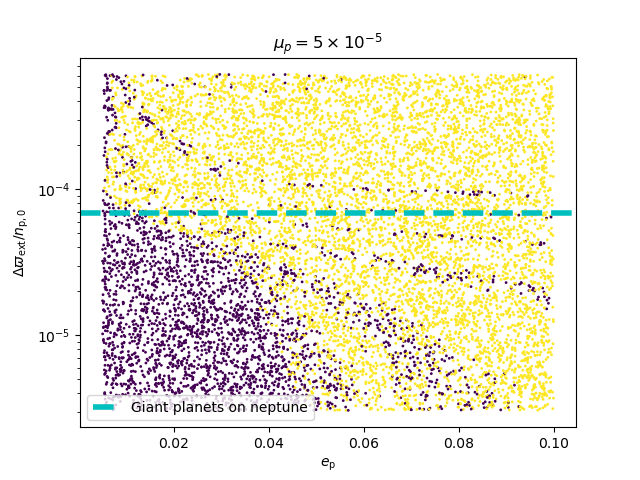

In [31]:
fig, ax = plt.subplots()
ax.scatter(eps,omps-oms,c=outcomes,s=1)
ax.set_yscale("log")
ax.set_ylabel(r"$\Delta\varpi_{\rm ext}/n_{\rm p,0}$")
ax.set_xlabel(r"$e_{\rm p}$")
ax.set_title(r"$\mu_p=5\times 10^{-5}$")
ax.axhline(y=DPOM_GPS,c="c",ls="--",lw=4,label="Giant planets on neptune")
#fig.savefig("Neptune Capture.png",dpi=300,bbox_inches="tight")
ax.legend()

### KNN

In [162]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [43]:
scaler = StandardScaler(with_mean=True, with_std=True, copy=True)
scaler.fit(X)
X_std = scaler.transform(X)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X_std, outcomes, test_size=0.2, random_state=42
)

In [ ]:
DecisionBoundaryDisplay.from_estimator?

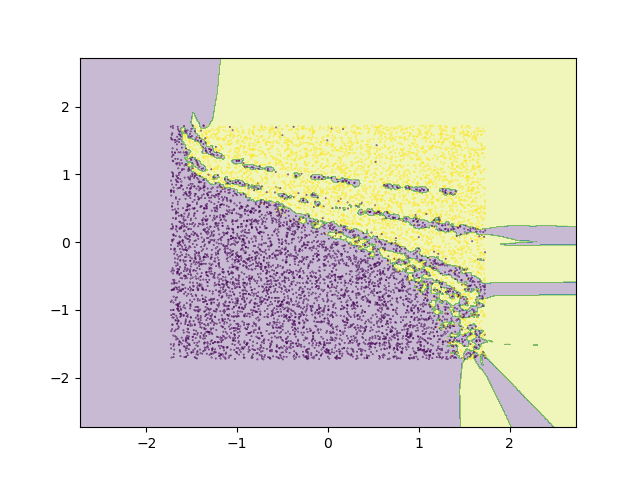

In [46]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
disp = DecisionBoundaryDisplay.from_estimator(
    knn, X_train, response_method="predict", alpha=0.3, grid_resolution=1000
)
disp.ax_.scatter(X_train[:, 0], X_train[:, 1],c=y_train,s=0.1)
ax.set_ylims(())

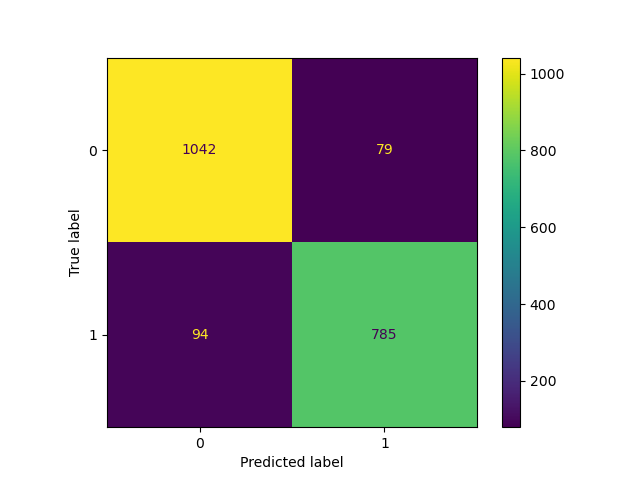

In [130]:
disp = ConfusionMatrixDisplay(confusion_matrix(knn.predict(X_test), y_test))
disp.plot()
plt.show()

## No Bp and No Sec investigation

- These were ran by setting beta_p = 0 for nobp, and b1_3_2=b2_3_2=0 for no secular

### No bp

In [23]:
TMVAL = 2*npy.pi*1e6
with open("results_mup5e-5_tm2pi1e6_n1.55_omalpha0val3.5_random10000_nobp.pkl", "rb") as f:
    jobs, results = pickle.load(f)

N_jobs = len(results)
eps = npy.zeros(N_jobs)
omps = npy.zeros(N_jobs)
oms = npy.zeros(N_jobs)
outcomes = npy.zeros(N_jobs)
X = npy.zeros((N_jobs,2))

for i in range(N_jobs):
    eps[i] = jobs[i][1]
    omps[i] = jobs[i][2]
    oms[i] = jobs[i][3]
    X[i,0]= jobs[i][1]
    X[i,1]= npy.log10(jobs[i][2])
    if len(results[i].t_events[0]) > 0:
        outcomes[i] = 1
print(npy.sum(outcomes))

5735.0


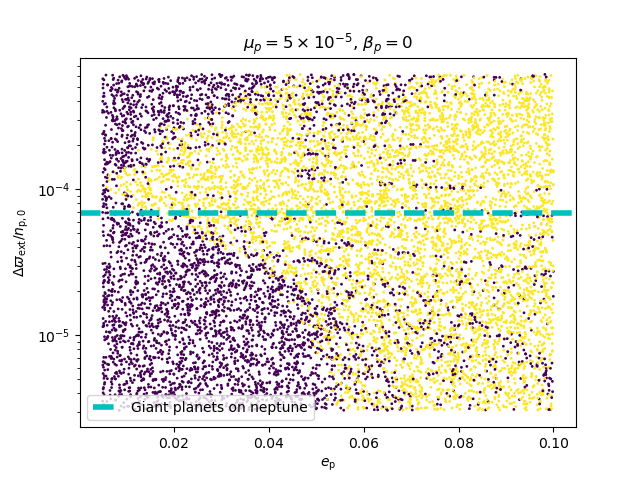

In [ ]:
fig, ax = plt.subplots()
ax.scatter(eps,omps-oms,c=outcomes,s=1)
ax.set_yscale("log")
ax.set_ylabel(r"$\Delta\varpi_{\rm ext}/n_{\rm p,0}$")
ax.set_xlabel(r"$e_{\rm p}$")
ax.set_title(r"$\mu_p=5\times 10^{-5}$, $\beta_p=0$")
ax.axhline(y=DPOM_GPS,c="c",ls="--",lw=4,label="Giant planets on neptune")
ax.legend()
#fig.savefig("Neptune Capture Nobp.png",dpi=300,bbox_inches="tight")

### No sec

In [25]:
TMVAL = 2*npy.pi*1e6
with open("results_mup5e-5_tm2pi1e6_n1.55_omalpha0val3.5_random10000_nosec.pkl", "rb") as f:
    jobs, results = pickle.load(f)

N_jobs = len(results)
eps = npy.zeros(N_jobs)
omps = npy.zeros(N_jobs)
oms = npy.zeros(N_jobs)
outcomes = npy.zeros(N_jobs)
X = npy.zeros((N_jobs,2))

for i in range(N_jobs):
    eps[i] = jobs[i][1]
    omps[i] = jobs[i][2]
    oms[i] = jobs[i][3]
    X[i,0]= jobs[i][1]
    X[i,1]= npy.log10(jobs[i][2])
    if len(results[i].t_events[0]) > 0:
        outcomes[i] = 1
print(npy.sum(outcomes))

7697.0


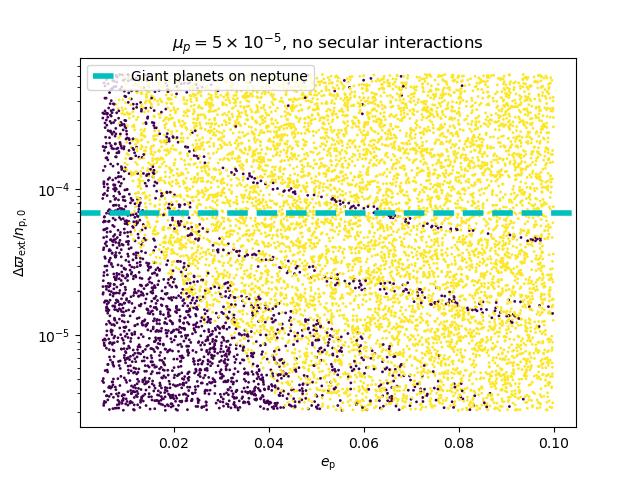

In [28]:
fig, ax = plt.subplots()
ax.scatter(eps,omps-oms,c=outcomes,s=1)
ax.set_yscale("log")
ax.set_ylabel(r"$\Delta\varpi_{\rm ext}/n_{\rm p,0}$")
ax.set_xlabel(r"$e_{\rm p}$")
ax.set_title(r"$\mu_p=5\times 10^{-5}$, no secular interactions")
ax.axhline(y=DPOM_GPS,c="c",ls="--",lw=4,label="Giant planets on neptune")
ax.legend()
#fig.savefig("Neptune Capture Nosec.png",dpi=300,bbox_inches="tight")

## Individual Runs

## Plotting function

In [198]:
def plot(results, ind, fig, axes, color, t1, t2):
    t_ind1 = 0
    t_ind2 = -1
    t_ind1 = npy.where(results[ind].t > t1)[0][0]
    t_ind2 = npy.where(results[ind].t > t2)[0][0]

    tint = results[ind].t[t_ind1:t_ind2]
    nint = results[ind].y[0, t_ind1:t_ind2]
    npint = npy.exp(-results[ind].t[t_ind1:t_ind2] / TMVAL)
    eint = results[ind].y[1, t_ind1:t_ind2]
    pomint = results[ind].y[2, t_ind1:t_ind2]
    thpint = results[ind].y[3, t_ind1:t_ind2]
    alphaint = (nint / npint) ** (2.0 / 3)
    bint = 1.8956507412695471
    mupint = 5e-5
    ompint = jobs[ind][2]
    omint = jobs[ind][3]
    aint = nint**(2./3)

    print(jobs[ind])
    ax = axes[0]
    ax.set_ylabel(r"$n/n_{\rm p}$")
    ax.scatter(
        tint,
        nint / npint,
        #aint,
        s=0.01,
        c=color,
    )
    #ax.scatter(
    #    tint,
    #    nint*aint**2*(1-0.5*(2+1)*eint**2),
    #    s=0.01,
    #    c="c",
    #)

    ax = axes[1]
    ax.set_ylabel(r"$\theta$")
    ax.scatter(
        tint,
        (thpint + ompint * tint - pomint) % (2 * npy.pi),
        s=0.01,
        c=color,
    )

    ax = axes[2]
    ax.set_ylabel(r"$\theta_{\rm p}$")
    ax.scatter(
        tint,
        thpint % (2 * npy.pi),
        s=0.01,
        c=color,
    )

    #ax = axes[3]
    #ax.set_ylabel(r"$\varpi$")
    #ax.scatter(
    #    tint,
    #    pomint % (2 * npy.pi),
    #    s=0.01,
    #    c=color,
    #)

    ax = axes[3]
    ax.set_ylabel(r"$\varpi_{\rm p}-\varpi$")
    ax.scatter(
        tint,
        (ompint * tint - pomint) % (2 * npy.pi),
        s=0.01,
        c=color,
    )
    #ax.axhline(y=npy.pi,c="c",ls="--")
    #ax.axhline(y=3*npy.pi/2,c="m",ls="--")
    #ax.axhline(y=npy.pi/2,c="m",ls="--")

    ax = axes[4]
    ax.set_ylabel(r"$e$")
    ax.scatter(
        tint,
        eint,
        s=0.01,
        c=color,
    )
    # lims = ax.get_ylim()
    # ax.plot(tint, -mupint*bint*nint*alphaint**(-1)/(3*nint-2*npint-omint))
    # ax.set_ylim(lims)

    for ax in axes:
        ax.set_xlim((tint[0], tint[-1]))
    for ax in axes[1:4]:
        ax.set_ylim((0, 2 * npy.pi))
    for ax in axes[:-1]:
        ax.set_xticklabels([])
    axes[-1].set_xlabel(r"$n_{\rm p}t$")
    axes[4].set_ylim(bottom=0)
    fig.subplots_adjust(hspace=0.1)

def moving_average(u, t, T):
    dt = npy.diff(t)[0]
    NT = int(T/dt)
    NS = npy.ones(NT)/NT
    out = npy.apply_along_axis(npy.convolve, axis=0, arr=u, v=NS, mode='same')
    return(out)

# One degree of freedom $\theta$

Throughout, I basically treat $\Gamma=\frac12\sqrt{GMa_0}e^2$ and $a_0$ is the SMA corresponding to $(j+1)n=jn_p$. There should be a slight difference in $a_0$ when things are precessing, but i don't think it impacts the dynamics beyond shifting the resonance center (i.e., its a second order effect everywhere else). Should probably incorporate it somehow into the definition of $k$.. or maybe do everything for $\omega=0$ and then shift the separatrix up in $n-\theta$ space?

I believe I have now accounted for it with the definition of $a_{\rm c}$, no?

### $H$ and $a_c$

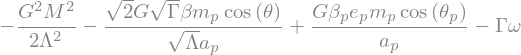

In [69]:
H

Define $a_c\longleftrightarrow n_c$ by the relation
$$
(j+1)n_c-jn_p-\omega=0
$$

Is this definition square with an apsidally precessing resonance?

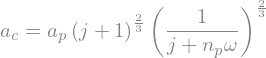

In [70]:
ac = symbols(r"a_{c}", positive=True)
display(Eq(ac, ap * ((j + 1) / (j+om*np)) ** Rational(2, 3)))

Suppose $\Lambda\simeq\sqrt{GMa_c}$ in denominator of resonant term.

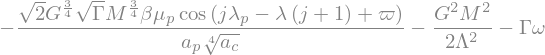

In [71]:
Hth = H.subs(
    {bp: 0, 
    th: (j + 1) * l - j * lp - pom, 
    ap * sqrt(Lam): ap * (G * M * ac)**Rational(1,4),
    mp: M*mup}
)
Hth

### Generating function 0

In [72]:
Gr, pomr = symbols(r"\Gamma_r \varpi_r")
S0 = Gr*om*t - Gr*pom
display(S0)

In [73]:
display(Eq(-pomr,S0.diff(Gr)))
display(Eq(Gam,-S0.diff(pom)))

Time dependent part of $S_r$

In [74]:
S0.diff(t)

In [75]:
solve(Eq(-pomr,S0.diff(Gr)),pom)[0]

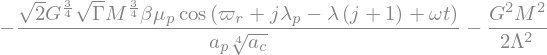

In [76]:
Hthr = Hth.subs({
    pom: solve(Eq(-pomr,S0.diff(Gr)),pom)[0]
}) + S0.diff(t).subs({Gr:solve(Eq(Gam,-S0.diff(pom)),Gr)[0] })
display(Hthr)

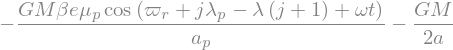

In [77]:
display(
    Hthr.subs({Gam: Rational(1, 2) * sqrt(G * M * ac) * e**2, Lam: sqrt(G * M * a)})
)

### Generating function 1

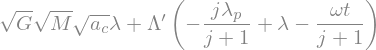

In [78]:
L1, l1 = symbols(r"\Lambda' \lambda'")
S1 = L1 * (l - j * lp / (j + 1) -om*t/(j+1)) + l * sqrt(G * M * ac)
display(S1)

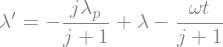

In [79]:
display(Eq(l1,S1.diff(L1)))
display(Eq(Lam,S1.diff(l)))

This way, $\Lambda'$ is small near resonance.

Time dependence of generating function $S'$.

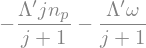

In [80]:
display(S1.diff(lp)*np + S1.diff(t))

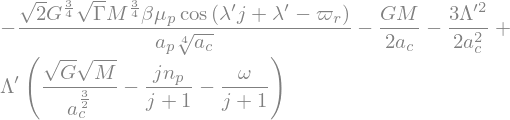

In [81]:
Hth1 = (
    Hthr.subs({l: solve(l1 - S1.diff(L1), l)[0], Lam: S1.diff(l)})
    + S1.diff(lp) * np
    + S1.diff(t)
)
Hth1 = Hth1.taylor_term(0, L1) + Hth1.taylor_term(1, L1) + Hth1.taylor_term(2, L1)
Hth1

We see the terms linear in $\Lambda'$ cancel out based on the definition of $a_{\rm c}$.

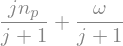

In [82]:
(np*(j+om/np)/(j+1)).expand()

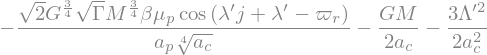

In [83]:
Hth1 = Hth1.subs(
    {sqrt(G * M) / ac ** Rational(3, 2): (np * (j + om / np) / (j + 1)).expand()}
)
Hth1

### Generating function 2

In [84]:
L2, l2, G2 = symbols(r"\Lambda'' \lambda'' \Gamma''")
S2 = G2 * ((j + 1) * l1 - pomr) + L2 * l1
display(S2)

In [85]:
display(Eq(Gam, -S2.diff(pomr)))
display(Eq(L1, S2.diff(l1)))
display(Eq(th, S2.diff(G2)))
display(Eq(l2, S2.diff(L2)))

Check $\theta$ is indeed $=\theta$ as defined at the beginning of the paper.

In [86]:
term_simplify(S2.diff(G2).subs(l1,S1.diff(L1))).subs(pomr,-S0.diff(Gr))

Success

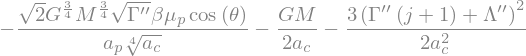

In [87]:
Hth2 = Hth1.subs(
    {
        Gam: -S2.diff(pomr),
        L1: S2.diff(l1),
        pomr: solve(th - S2.diff(G2), pomr)[0],
    }
)
Hth2

### Conserved quantity

$\Lambda''$ is a conserved quantity.

In [131]:
Eq(L2, solve(L1 - S2.diff(l1), L2)[0].collect(G2).collect(j+1))

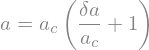

In [132]:
da = symbols(r"\delta{a}")
display(Eq(a,ac*(1+da/ac)))

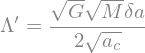

In [133]:
display(Eq(L1,Lam-sqrt(G*M*ac)))
display(Eq(L1,(sqrt(G*M*ac*(1+da/ac))-sqrt(G*M*ac)).taylor_term(1,da)))

Here we assume $\Gamma''\approx\frac12\sqrt{GMa_0}e^2$ in the definition of $\Lambda''$ and $k$... is this reasonable?

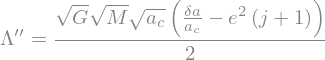

In [134]:
display(Eq(L2,
term_multiply(solve(L1 - S2.diff(l1), L2)[0].collect(G2).collect(j + 1).subs(
    {
        G2: Rational(1, 2) * sqrt(G * M * ac) * e**2,
        L1: (sqrt(G*M*ac*(1+da/ac))-sqrt(G*M*ac)).taylor_term(1,da),
    }
).collect(Rational(1,2)*sqrt(G*M*ac))
, 2/sqrt(G*M*ac))
*sqrt(G*M*ac)/2)
)

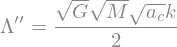

In [135]:
display(Eq(L2, Rational(1,2)*sqrt(G*M*ac)*k))

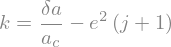

In [136]:

display(Eq(k,
term_multiply(solve(L1 - S2.diff(l1), L2)[0].collect(G2).collect(j + 1).subs(
    {
        G2: Rational(1, 2) * sqrt(G * M * ac) * e**2,
        L1: (sqrt(G*M*ac*(1+da/ac))-sqrt(G*M*ac)).taylor_term(1,da),
    }
).collect(Rational(1,2)*sqrt(G*M*ac)),1/(Rational(1,2)*sqrt(G*M*ac)))
))

### Final Hamiltonian

Separate the Hamiltonian into "radial" and resonant parts.

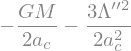

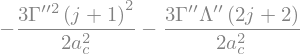

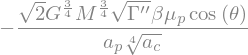

In [137]:
Hth2rad = Hth2.subs({b:0})
Hth2const = Hth2rad.taylor_term(0,G2)
Hth2res = Hth2-Hth2rad
Hth2rad = Hth2rad.taylor_term(1,G2) + Hth2rad.taylor_term(2,G2)
display(Hth2const)
display(Hth2rad)
display(Hth2res)

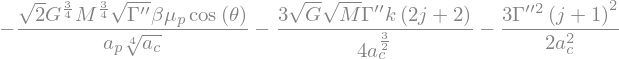

In [138]:
Hthf = (Hth2rad + Hth2res).subs(
    {
        L2: Rational(1, 2) * sqrt(G * M * ac) * k,
        #sqrt(G * M / a0): sqrt(alpha0) * np * ap,
        #k:k/sqrt(G*M)*a0**Rational(3,2)*j*np*2/(2*j+2)
    }
)
Hthf

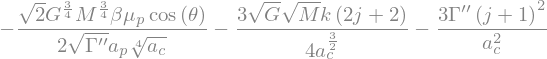

In [139]:
Hthf.diff(G2)

Now set the $\Gamma''=\frac12\sqrt{GMa_c}e^2$... Is this reasonable?

In [140]:
def term_expand(expr):
    run = 0
    for arg in expr.args:
        run += arg.expand()
    return(run)

THis expression is nicer but gives weird time units:

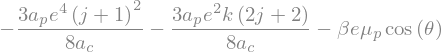

In [141]:
term_multiply(Hthf.subs({G2: Rational(1, 2)*sqrt(G*M*ac) * e**2}), 1/(G*M/ap))

In [142]:
def term_cancel(expr):
    run = 0
    for arg in expr.args:
        run += arg.cancel().factor()
    return(run)

Units of $n_p$:

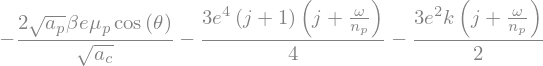

In [143]:
term_cancel(term_multiply(
    Hthf.subs({G2: Rational(1, 2) * sqrt(G * M * ac) * e**2}),
    1 / (G * M / ap / sqrt(ap / ac) / 2),
)).subs(
    {
        ap ** Rational(3, 2) / ac ** Rational(3, 2): (j+om/np)/(j+1),
    }
)

### Scaled Hamiltonian and $k_{\rm sep}$

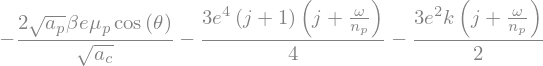

In [88]:
H_scaled0 = -(Rational(3,4)*(j+1)*(j+om/np)*e**4).collect(Rational(3,4)) - ((Rational(3,2)*(j+om/np)*k)*e**2).collect(Rational(3,2)) - 2*sqrt(ap/ac)*b*mup*e*cos(th)
H_scaled0

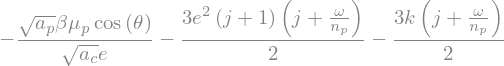

In [89]:
thdot = term_multiply(H_scaled0.diff(e),1/(2*e))
thdot

The below expression agrees with $\dot e$ in paper once you change to units of $n$ (assuming $n_p/n=\alpha^{3/2}\simeq\alpha_0^{3/2}$)

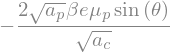

In [90]:
-H_scaled0.diff(th)

Must solve this equation to find stable values of $e$ as a function of $k$... first finding critical value of $k$

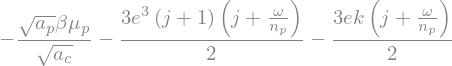

In [91]:
thdot_poly = term_multiply(thdot,e).subs(th, 0)#term_multiply(thdot, -j*e / (3 * j * (j + 1) / 2)).subs(th, 0)
display(thdot_poly)

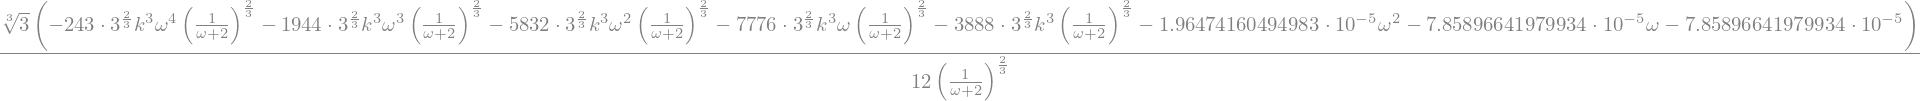

In [96]:
expr1 = (
    discriminant(thdot_poly, e)
    .subs(
        {
            j: 2,
            np: 1,
            ac: ap * ((j + 1) / (j + om)) ** Rational(2, 3),
            b: 1.8956507412695471,
        }
    )
    .subs(
        {
            ap: 1,
            mup: 5e-5,
        }
    )
)
display(expr1)

Now for the $\omega=0$ critical value. Is it worth it to solve for general $\omega$ and $\mu_{\rm p}$?

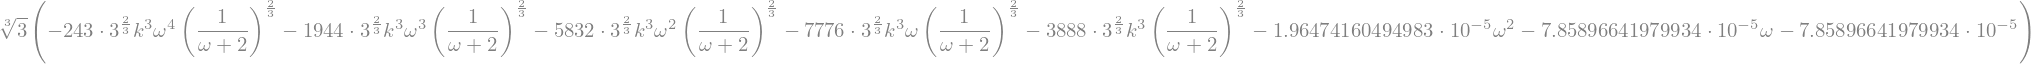

In [98]:
funcl = fraction(expr1)[0]
funcl

In [104]:
nsolve?

Signature: nsolve(*args, dict=False, **kwargs)
Docstring:
Solve a nonlinear equation system numerically: ``nsolve(f, [args,] x0,
modules=['mpmath'], **kwargs)``.

Explanation

``f`` is a vector function of symbolic expressions representing the system.
*args* are the variables. If there is only one variable, this argument can
be omitted. ``x0`` is a starting vector close to a solution.

Use the modules keyword to specify which modules should be used to
evaluate the function and the Jacobian matrix. Make sure to use a module
that supports matrices. For more information on the syntax, please see the
docstring of ``lambdify``.

If the keyword arguments contain ``dict=True`` (default is False) ``nsolve``
will return a list (perhaps empty) of solution mappings. This might be
especially useful if you want to use ``nsolve`` as a fallback to solve since
using the dict argument for both methods produces return values of
consistent type structure. Please note: to keep this consistent with
``solve

In [106]:
nsolve(funcl.subs({om:0}),k,1e-3)

This expression agrees with the equation in the paper when you put in $\alpha_0$

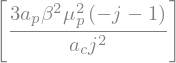

In [93]:
solve(expr1.subs(om,0),k**3)

Testing nsolve against analytic:

In [113]:
om0kcrit = (
    -solve(expr1.subs(om, 0), k**3)[0]
    .subs(
        {
            j: 2,
            np: 1,
            ac: ap * ((j + 1) / (j + om)) ** Rational(2, 3),
            b: 1.8956507412695471,
        }
    )
    .subs(
        {
            ap: 1,
            mup: 5e-5,
        }
    )
) ** (1.0 / 3)
print(om0kcrit)

0.00248932538600894


Success

### Dependence of $k_{\rm crit}$ on $\omega$

$k_{\rm crit}$ depends very weakly on $\omega$, even up to values of $0.1$ and negative values.

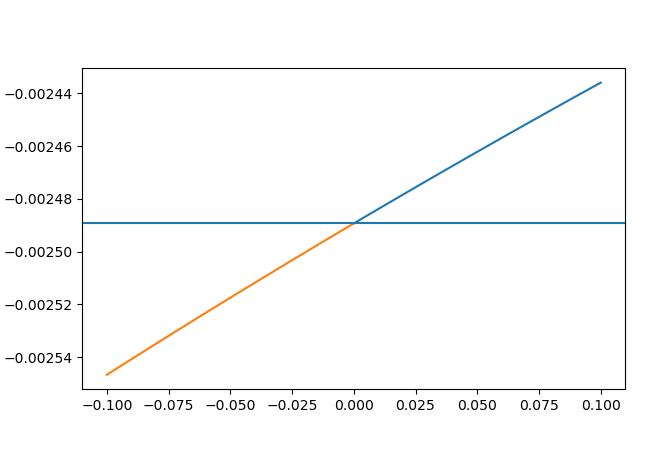

In [127]:
plt.clf()
omcritvals = npy.logspace(-6, -1, 100)

kcrits = npy.zeros(len(omcritvals))
for it, omval in enumerate(omcritvals):
    kcrits[it] = nsolve(funcl.subs({om: omval}), k, 1e-3)
plt.plot(omcritvals,kcrits)

kcrits = npy.zeros(len(omcritvals))
for it, omval in enumerate(-omcritvals):
    kcrits[it] = nsolve(funcl.subs({om: omval}), k, 1e-3)

plt.plot(-omcritvals,kcrits)

plt.axhline(y=-om0kcrit)
plt.show()

### Plotting Runs with $e_{\rm p}=0$ to compare to approximate Hamiltonian

    bp: 1.5455341716765871,

In [42]:
TMVAL = 2*npy.pi*1e6
with open("ep0_mup5e-5_tm2pi1e6_n1.6_omalpha0val3.5.pkl", "rb") as f:
    jobs, results = pickle.load(f)

In [43]:
jobs

In [44]:
def func(t):
    if t > 2 * npy.pi * 3e5:
        npval = npy.exp(-2 * npy.pi * 3e5 / TMVAL)
    else:
        npval = npy.exp(-t / TMVAL)
    return npval

In [62]:
ind=0
#t1 = 2.4e5
#t2 = 2.6e5
t_ind1 = 0
t_ind2 = -1
#t_ind1 = npy.where(results[ind].t > t1)[0][0]
#t_ind2 = npy.where(results[ind].t > t2)[0][0]
tint = results[ind].t[t_ind1:t_ind2]
nint = results[ind].y[0, t_ind1:t_ind2]
npint = npy.array([func(tval) for tval in tint])
eint = results[ind].y[1, t_ind1:t_ind2]
pomint = results[ind].y[2, t_ind1:t_ind2]
thpint = results[ind].y[3, t_ind1:t_ind2]
ompint = jobs[ind][2]
omint = jobs[ind][3]
alphaint = (nint / npint) ** (2.0 / 3)
bint = 1.8956507412695471
aint = nint**(-2./3)

In [63]:
#t1 = 2.46874e5#2.2e5
#t2 = 2.47005e5
#no_prec = [(thpint + ompint*tint - pomint) %(2*npy.pi), aint]

#t1 = 2.56917e5
#t2 = 2.57045e5
#prec = [(thpint + ompint*tint - pomint) %(2*npy.pi), aint]

In [64]:
-1.83*5e-5**(2./3)

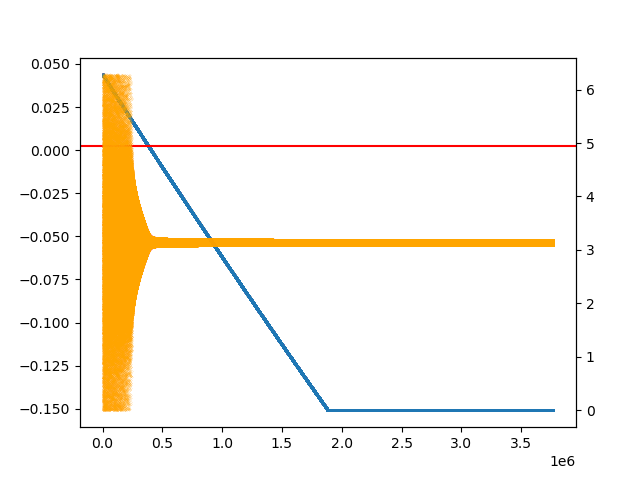

In [65]:
fig, ax = plt.subplots()
#ax.scatter(prec[0], prec[1])
#ax.scatter(no_prec[0], no_prec[1])
#ax.scatter((thpint + ompint*tint - pomint) %(2*npy.pi), aint, c=tint)
ax.twinx().scatter(tint, (thpint + ompint*tint - pomint) %(2*npy.pi), c="orange",s=0.01)
#ax.scatter(tint,(thpint + ompint*tint - pomint) %(2*npy.pi),s=0.01)
kint = aint/((npint*2/3)**(-2./3))-1-3*eint**2
#daint = aint/((npint*2/3)**(-2./3))-1
ax.scatter(tint,kint,s=0.01 )#- npy.average(kint[-1000:]),s=0.01)
#ax.scatter(tint,nint/npint,s=0.01)
#ax.scatter(tint,daint,s=0.01)
#ax.scatter(tint,eint,s=0.01)
ax.axhline(y=0.0024837,c="r")
#ax.axhline(y=2/3)
#ax.twinx().scatter(tint,eint,s=0.01,c="orange")# - npy.average(daint[-1000:]),s=0.01)
#ax.scatter(tint,3*eint**2 - npy.average(3*eint[-1000:]**2),s=0.01)
#ax.set_ylim(0,2*npy.pi)
#ax.scatter(tint,results[1].y[0, t_ind1:t_ind2]-results[0].y[0, t_ind1:t_ind2],s=0.1)

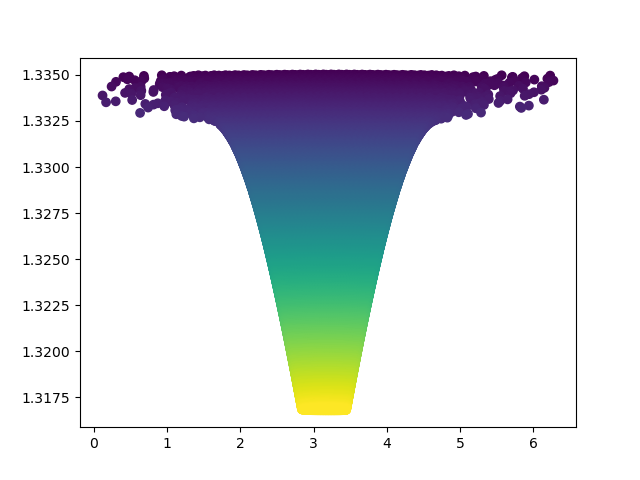

In [80]:
fig, ax = plt.subplots()
t1, t2 = npy.where(tint>23e4)[0][0], npy.where(tint>36e4)[0][0]
#ax.scatter(tint,(npint)**(-2./3))
ax.scatter((thpint + ompint*tint - pomint)[t1:t2] %(2*npy.pi), aint[t1:t2]/(npint[t1:t2])**(-2./3), c=tint[t1:t2])
#ax.scatter((thpint)[t1:t2] %(2*npy.pi), aint[t1:t2], c=tint[t1:t2])

In [70]:
(3/2)**(2/3)

In [157]:
jobs[1][3]/4

In [158]:
prec-no_prec

NameError: name 'prec' is not defined

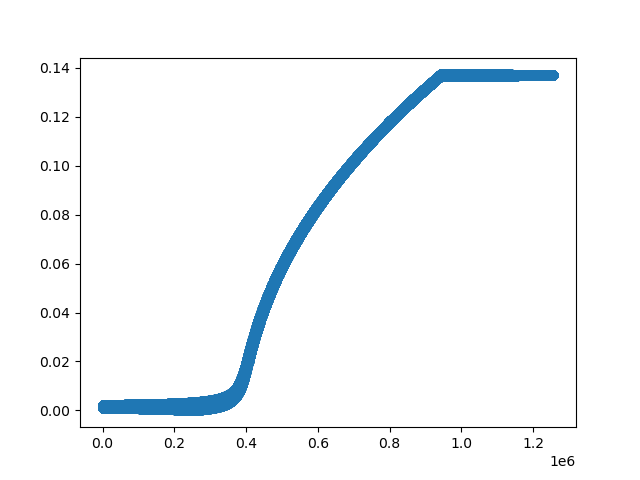

In [ ]:
fig.show()

In [ ]:
alpha0val = (2 / 3) ** (2.0 / 3)
epvals = npy.linspace(5e-3,0.1,20)
ompvals = npy.zeros(31)
ompvals[1:] = npy.logspace(-5, -2.7865, 30)
samples = []
for i, epval in enumerate(epvals):
    for k, ompval in enumerate(ompvals):
        samples = samples + [(len(ompvals) * i + k, epval, ompval, ompval * alpha0val**3.5)]


selects =[12, 198, 384, 570,26, 212, 398, 584,5, 98, 191, 284, 377, 470, 563,19, 112, 205, 298, 391, 484, 577] + [119,105,305,291,491,477] 
jobs = []
for select in selects:
    for sampind, thetap0 in enumerate(npy.linspace(0,2*npy.pi,100,endpoint=False)):
        jobs = jobs + [(*samples[select], thetap0, sampind)]

for i in range(0,20,3):
    for k in range(5,30,7):
        ind = len(ompvals)*i+k
        print(ind, ind in selects)

5 True
12 True
19 True
26 True
98 True
105 True
112 True
119 True
191 True
198 True
205 True
212 True
284 True
291 True
298 True
305 True
377 True
384 True
391 True
398 True
470 True
477 True
484 True
491 True
563 True
570 True
577 True
584 True


In [ ]:
ls = []
for i in range(0,20,2):
    for k in range(5,30,3):
        ls = ls + [len(ompvals)*i+k]
print(ls)

[5, 8, 11, 14, 17, 20, 23, 26, 29, 67, 70, 73, 76, 79, 82, 85, 88, 91, 129, 132, 135, 138, 141, 144, 147, 150, 153, 191, 194, 197, 200, 203, 206, 209, 212, 215, 253, 256, 259, 262, 265, 268, 271, 274, 277, 315, 318, 321, 324, 327, 330, 333, 336, 339, 377, 380, 383, 386, 389, 392, 395, 398, 401, 439, 442, 445, 448, 451, 454, 457, 460, 463, 501, 504, 507, 510, 513, 516, 519, 522, 525, 563, 566, 569, 572, 575, 578, 581, 584, 587]


In [ ]:
len(ls)

# Separatrix